# What is an EMU basis vector?

 [Crown and Antoniewicz, 2012](http://linkinghub.elsevier.com/retrieve/pii/S1096717611001273)  provide an algorithm for determining which fluxes are observable given a selection of tracers for 13C-metabolic flux analysis. Consider the network in figure 1.  The input metabolite $A$ has 3 atoms, and the output metabolite $E$ also has 3 atoms.  E can be generated directly from $A$ from flux $v_1$ to $v_2$, or from $v_1$, it can be split into two moieties by  $v_3$ which are then recombined in $v_4$ and finally end up at $E$ through $v_2$.


* **Elementary Metabolite Units (EMU)** are distinct subsets of the compound's atoms.  There are 7 EMU's for a 3-atom metabolite $A$ shown in the figure from [Antoniewicz 2007](http://linkinghub.elsevier.com/retrieve/pii/S109671760600084X) below. The subscript in the first column and the shaded areas in the second column denote the atoms that are included in the EMU. The EMU size is the number of atoms included in the EMU.
* An **EMU network** is a set of EMU's and the transitions between them.  The network can be restricted to EMUs of a particular size (Figure 3A), or it can be combined into a larger network composed of EMU's of all sizes (Figure 3B).
*  **EMU basis vector** can be viewed as a unique way for assembling substrate EMUs to form the product. By definition, EMU basis vectors have the same EMU size as the product. Ultimately, one can interpret the Mass Isotopic Distribution (MID) of the product as a linear combination of EMU basis vector MIDs, where the coefficients are solely a function of free fluxes. The coefficients quantify the fractional contribution of each EMU basis vector to the product. Thus, by definition, the sum of the coefficients must equal one. 
* In addition to the EMU basis vector, Crown et al also define an **EMU pathway**. Each EMU basis vector specifies a unique EMU pathway from substrate(s) to product. 
* An **Elementary mode (ELMO)** of a network is a minimal cardinality set of reactions that form a steady-state. Minimal cardinality means that no steady-state flux distribution can be a subset of an elementary mode.  The set of elementary modes forms a basis for steady-state flux space.
* Assertion: The elementary modes of the EMU network are the EMU pathways. Proof is by demonstration, below

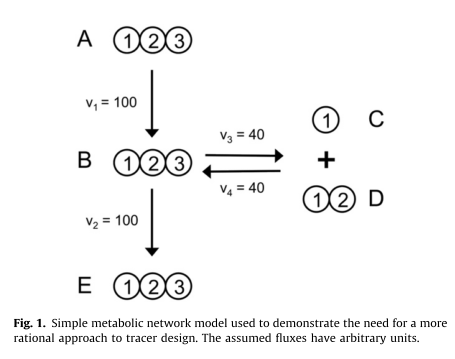

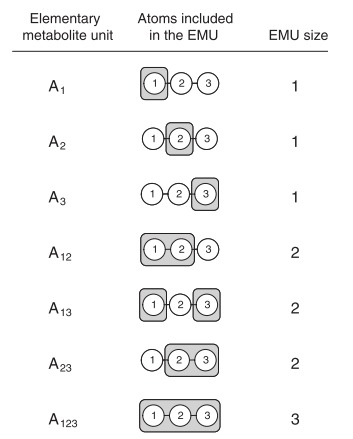

In [232]:
from IPython.display import Image, display
display(Image('Figure1.png'))
display(Image('EMU_definition.png'))


## Figure 3 Combined EMU network ##

The network in Fig. 1 was decomposed into its respective EMU
networks as shown in Fig. 3A. The size 3 EMU network demonstrates that the network product, $E_{123}$, can be formed via two EMU pathways: one pathway from $A_{123}$ via reactions $v_1$ and $v_2$,and a second pathway from $D_{12}$ and $C_1$ via reactions $v_4$ and $v_2$. EMUs $D_{12}$ and $C_1$ can be further traced to $A_{12}$ and $A_3$, respectively. Fig. 3B shows the combined EMU model. For this simple system, it was possible to derive an analytical solution to the EMU network model:

$$E_{123} = \frac{v_1}{v_1 + v_4}\cdot A_{123} + \frac{v_4}{v_1+v_4}\cdot\left(A_{12}\times A_{3}\right)$$


### Figure 3


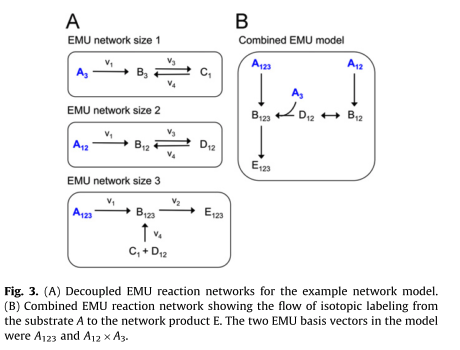

### Combined EMU network


### EMU basis vectors 


,A_1_2_3,A_1_2,A_3,E_1_2_3,EMU Basis Vector
EM1,-1.0,-0.0,-0.0,1.0,$A_{123}$
EM2,-0.0,-1.0,-1.0,1.0,$A_{12}\times A_{3}$


### EMU Pathways ###


,R1,R2,R3,R4,R5,R6,R7,R8,R9,EMU Basis Vector
EM1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,$A_{123}$
EM2,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,$A_{12}\times A_{3}$


#### EMU Pathway EM1 ($A_{123}$)


#### EMU Pathway EM2 ($A_{12}\times A_{3}$)


In [234]:
import pandas as pd
import numpy as np
import scipy, sympy
from cobra import Metabolite, Reaction, Model
import cobra
import sys
sys.path.append('/Users/zuck016/Projects/src')
from myefm import calculate_elementary_modes, calculate_minimum_cut_sets
from d3flux import flux_map
from IPython.display import display, Image, SVG, Markdown,Latex, HTML

def sympy2array( sy ):
    return np.array(sy.tolist(), dtype=float)

def get_EMU_basis_vector_name( emu_basis_vector ):
    """The EMU basis vector naming scheme is generated automatically from the EMU basis vector."""
    bv_name = []
    for met in emu_basis_vector.index:
        latex_met = met.split('_')
        latex_met = '%s_{%s}' % (latex_met[0], ''.join(latex_met[1:]))
        stoich = emu_basis_vector[met]
        if stoich < 0:
            if stoich == -1:

                bv_name.append( latex_met )
            else:
                bv_name.append( r'\left(' + latex_met + r'\right)^' + '{%d}' % -int(stoich))
    return '${}$'.format(r'\times '.join(bv_name))
def get_stoichiometric_matrix( network ):
    return pd.DataFrame(cobra.util.create_stoichiometric_matrix(network), 
                    index=[m.id for m in emu_network.metabolites],
                    columns = [r.id for r in emu_network.reactions])

def get_EMU_basis_vectors_and_pathways( network, external_rxns,external_mets, output_met, output_rxn ):
    """The EMU pathways are generated by calculating the elementary modes of the EMU Network.  The EMU basis vectors are constructed by transforming each elementary mode from a set of reactions to the corresponding set of external metabolites.  The transformation is restricted to external reactions so that the stoichiometry of the EMU basis vectors works out correctly.  The EMU pathways are normalized by the ELMO coefficient of the output reaction. The EMU basis vectors are normalized by the  EMU basis vector coefficient of the output metabolite"""
    S = get_stoichiometric_matrix( network )
    elmos = calculate_elementary_modes( network, verbose=False)
    elmos = elmos.T.divide(elmos[output_rxn]).T

    EMU_basis_vector = elmos[external_rxns].dot(S[external_rxns].T)[external_mets]
    EMU_basis_vector = EMU_basis_vector.T.divide(EMU_basis_vector[output_met]).T
    for em in EMU_basis_vector.index:
        EMU_basis_vector.loc[em,'EMU Basis Vector'] = get_EMU_basis_vector_name( EMU_basis_vector.loc[em] )
    return EMU_basis_vector, elmos
def get_nullspace( df ):
    basis_vectors = sympy.Matrix(S.values).nullspace()
    return pd.DataFrame(dict([('bv{}'.format(i), 
                        np.squeeze(np.array(bv.tolist(), dtype=float))) 
                        for i,bv in 
                            enumerate(basis_vectors)]),
                        index=df.columns)
def get_nullspace_rref( df ):
    nullspace = get_nullspace( df )
    rref, pivot_vars = sympy.Matrix(nullspace.values).rref()
    return pd.DataFrame(np.array(rref.tolist(), dtype=float),
                index= rxns), [df.columns[v] for v in pivot_vars]

emu_network = Model('figure3_combined_EMU_network')
A_1_2_3 = Metabolite('A_1_2_3')
A_1_2 = Metabolite('A_1_2')
A_3 = Metabolite('A_3')
B_1_2_3 = Metabolite('B_1_2_3')
D_1_2 = Metabolite('D_1_2')
B_1_2 = Metabolite('B_1_2')
E_1_2_3 = Metabolite('E_1_2_3')
R1 = Reaction('R1')
R2 = Reaction('R2')
R3 = Reaction('R3')
R4 = Reaction('R4')
R5 = Reaction('R5')
R6 = Reaction('R6')
R7 = Reaction('R7')
R8 = Reaction('R8')
R9 = Reaction('R9')
emu_network.add_metabolites([A_1_2_3, A_1_2, A_3, B_1_2_3, B_1_2, D_1_2, E_1_2_3])
emu_network.add_reactions([R1, R2, R3, R4, R5, R6, R7,R8, R9])

emu_network.reactions.R1.build_reaction_from_string('A_1_2_3 --> B_1_2_3')
emu_network.reactions.R2.build_reaction_from_string('B_1_2_3 --> E_1_2_3')
emu_network.reactions.R3.build_reaction_from_string('A_3 + D_1_2 --> B_1_2_3')
emu_network.reactions.R4.build_reaction_from_string('B_1_2 <--> D_1_2')
emu_network.reactions.R5.build_reaction_from_string('A_1_2 --> B_1_2')
emu_network.reactions.R6.build_reaction_from_string('--> A_1_2_3')
emu_network.reactions.R7.build_reaction_from_string('--> A_1_2')
emu_network.reactions.R8.build_reaction_from_string('--> A_3')
emu_network.reactions.R9.build_reaction_from_string('E_1_2_3 -->')

S = get_stoichiometric_matrix( emu_network )
rxns, mets = S.columns, S.index
external_mets = ['A_1_2_3', 'A_1_2' ,'A_3', 'E_1_2_3']
external_rxns = ['R6', 'R7', 'R8', 'R9']
output_met = 'E_1_2_3'
output_rxn = 'R9'
ebv, emu_elmo = get_EMU_basis_vectors_and_pathways( emu_network, external_rxns, external_mets, output_met,output_rxn)

display(Markdown('### Figure 3\n'))
display(Image('Figure3.png'))
display(Markdown('### Combined EMU network\n'))
display(flux_map(cobra.io.load_json_model("figure3_combined_EMU_network.json"), display_name_format=lambda x: str(x.id),
         flux_dict={rxn.id: emu_elmo.sum(axis=0)[rxn.id] for rxn in emu_network.reactions}))
#cobra.io.save_json_model(emu_network, "figure3_combined_emu_network.json",pretty=True)
display(Markdown('### EMU basis vectors \n'))
display(ebv)

display(Markdown('### EMU Pathways ###\n'))
emu_elmo['EMU Basis Vector']  = ebv['EMU Basis Vector']

display(emu_elmo)

for em in emu_elmo.index:
    with emu_network:
        emu_network.remove_reactions([r for r in emu_elmo.columns if emu_elmo.loc[em,r] == 0],remove_orphans=True)
        display(Markdown('#### EMU Pathway {} ('.format(em) + ebv.loc[em,'EMU Basis Vector' ]  + ')\n'))
        display(flux_map(emu_network,
                     display_name_format=lambda x: str(x.id),
                     flux_dict={rxn.id: emu_elmo.loc[em,rxn.id] 
                            for rxn in emu_network.reactions}))



In [81]:
nullspace = get_nullspace(S)
nullspace

,bv0,bv1
R1,-1.0,1.0
R2,0.0,1.0
R3,1.0,0.0
R4,1.0,0.0
R5,1.0,0.0
R6,-1.0,1.0
R7,1.0,0.0
R8,1.0,0.0
R9,0.0,1.0


In [88]:
rref, pivot_vars = get_nullspace_rref(S)
display(rref)
display(pivot_vars)

,0,1
R1,1.0,0.0
R2,0.0,1.0
R3,0.0,0.0
R4,0.0,0.0
R5,0.0,0.0
R6,0.0,0.0
R7,0.0,0.0
R8,0.0,0.0
R9,0.0,0.0


['R1', 'R2']

## Figure 7 combined EMU reaction network

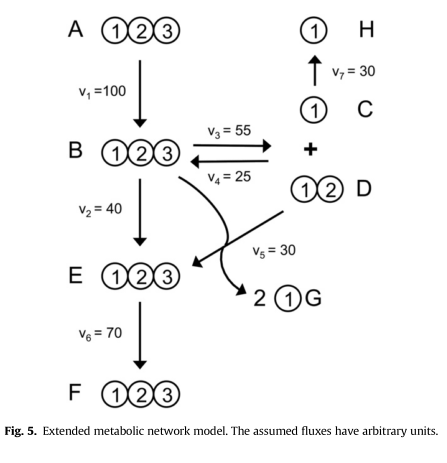

In [236]:
Image('Extended_EMU_network.png')

### Figure 7


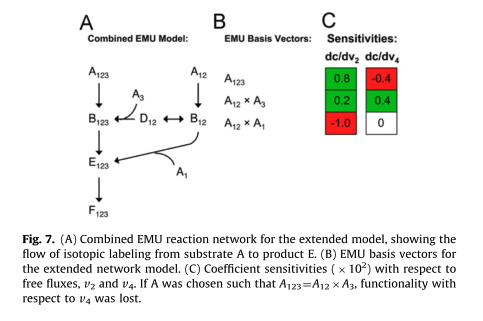

### Combined EMU network


### EMU basis vectors for $F_{123}$ 


,A_1,A_3,A_1_2,A_1_2_3,F_1_2_3,EMU Basis Vector
EM1,-1.0,-0.0,-1.0,-0.0,1.0,$A_{1}\times A_{12}$
EM2,-0.0,-1.0,-1.0,-0.0,1.0,$A_{3}\times A_{12}$
EM3,-0.0,-0.0,-0.0,-1.0,1.0,$A_{123}$


### EMU Pathways ###


,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,EMU Basis Vector
EM1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,$A_{1}\times A_{12}$
EM2,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,$A_{3}\times A_{12}$
EM3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,$A_{123}$


#### EMU Pathway EM1 ($A_{1}\times A_{12}$)


#### EMU Pathway EM2 ($A_{3}\times A_{12}$)


#### EMU Pathway EM3 ($A_{123}$)


In [226]:

emu_network = Model('figure7_combined_EMU_network')
A_1_2_3 = Metabolite('A_1_2_3')
A_1_2 = Metabolite('A_1_2')
A_3 = Metabolite('A_3')
A_1 = Metabolite('A_1')
B_1_2_3 = Metabolite('B_1_2_3')
D_1_2 = Metabolite('D_1_2')
B_1_2 = Metabolite('B_1_2')
E_1_2_3 = Metabolite('E_1_2_3')
F_1_2_3 = Metabolite('F_1_2_3')

R1 = Reaction('R1')
R2 = Reaction('R2')
R3 = Reaction('R3')
R4 = Reaction('R4')
R5 = Reaction('R5')
R6 = Reaction('R6')
R7 = Reaction('R7')
R8 = Reaction('R8')
R9 = Reaction('R9')
R10 = Reaction('R10')
R11 = Reaction('R11')
R12 = Reaction('R12')

emu_network.add_metabolites([A_1, A_1_2_3, A_1_2, A_3, B_1_2_3, B_1_2, D_1_2, E_1_2_3, F_1_2_3])
emu_network.add_reactions([R1, R2, R3, R4, R5, R6, R7,R8, R9, R10, R11, R12])

emu_network.reactions.R1.build_reaction_from_string('A_1_2_3 --> B_1_2_3')
emu_network.reactions.R2.build_reaction_from_string('B_1_2_3 --> E_1_2_3')
emu_network.reactions.R3.build_reaction_from_string('A_3 + D_1_2 --> B_1_2_3')
emu_network.reactions.R4.build_reaction_from_string('B_1_2 <--> D_1_2')
emu_network.reactions.R5.build_reaction_from_string('A_1_2 --> B_1_2')
emu_network.reactions.R6.build_reaction_from_string('--> A_1_2_3')
emu_network.reactions.R7.build_reaction_from_string('--> A_1_2')
emu_network.reactions.R8.build_reaction_from_string('--> A_3')
emu_network.reactions.R9.build_reaction_from_string('E_1_2_3 --> F_1_2_3')
emu_network.reactions.R10.build_reaction_from_string('B_1_2 + A_1 --> E_1_2_3')
emu_network.reactions.R11.build_reaction_from_string('F_1_2_3 -->')
emu_network.reactions.R12.build_reaction_from_string('--> A_1')

S = get_stoichiometric_matrix( emu_network )
rxns, mets = S.columns, S.index
external_mets = [ 'A_1','A_3', 'A_1_2', 'A_1_2_3', 'F_1_2_3']
external_rxns = ['R6', 'R7', 'R8', 'R11', 'R12']
output_met = 'F_1_2_3'
output_rxn = 'R11'
ebv, emu_elmo = get_EMU_basis_vectors_and_pathways( emu_network, external_rxns, external_mets, output_met,output_rxn)

#cobra.io.save_json_model(emu_network, "figure7_combined_emu_network.json",pretty=True)
display(Markdown('### Figure 7\n'))
display(Image('Figure7.png'))
display(Markdown('### Combined EMU network\n'))
display(flux_map(cobra.io.load_json_model("figure7_combined_EMU_network.json"), display_name_format=lambda x: str(x.id),
         flux_dict={rxn.id: emu_elmo.sum(axis=0)[rxn.id] for rxn in emu_network.reactions}))
display(Markdown('### EMU basis vectors for $F_{123}$ \n'))

display(ebv)


display(Markdown('### EMU Pathways ###\n'))
emu_elmo['EMU Basis Vector']  = ebv['EMU Basis Vector']

display(emu_elmo)

for em in emu_elmo.index:
    with emu_network:
        emu_network.remove_reactions([r for r in emu_elmo.columns if emu_elmo.loc[em,r] == 0],remove_orphans=True)
        display(Markdown('#### EMU Pathway {} ('.format(em) + ebv.loc[em,'EMU Basis Vector' ]  + ')\n'))
        display(flux_map(emu_network,
                     display_name_format=lambda x: str(x.id),
                     flux_dict={rxn.id: emu_elmo.loc[em,rxn.id] 
                            for rxn in emu_network.reactions}))


## Figure 12 Combined EMU network 

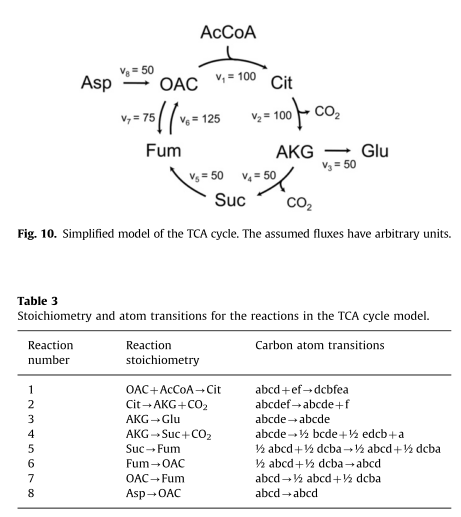

In [235]:
Image('TCA.png')

### Combined EMU network


### Figure 12


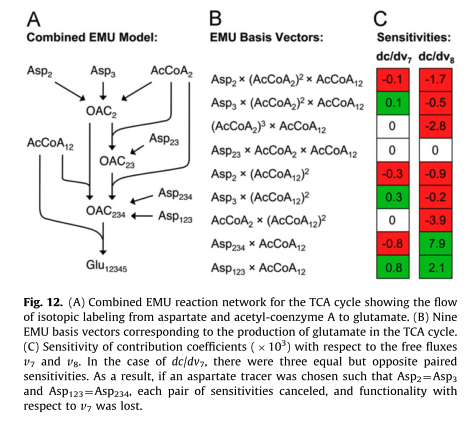

### EMU basis vectors 


,index,Asp_2,Asp_3,AcCoA_2,AcCoA_1_2,Asp_2_3,Asp_1_2_3,Asp_2_3_4,Glu_1_2_3_4_5
EMU Basis Vector,,,,,,,,,
$Asp_{2}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$,EM9,-1.0,-0.0,-2.0,-1.0,-0.0,-0.0,-0.0,1.0
$Asp_{3}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$,EM8,-0.0,-1.0,-2.0,-1.0,-0.0,-0.0,-0.0,1.0
$\left(AcCoA_{2}\right)^{3}\times AcCoA_{12}$,EM7,-0.0,-0.0,-3.0,-1.0,-0.0,-0.0,-0.0,1.0
$AcCoA_{2}\times AcCoA_{12}\times Asp_{23}$,EM1,-0.0,-0.0,-1.0,-1.0,-1.0,-0.0,-0.0,1.0
$Asp_{2}\times \left(AcCoA_{12}\right)^{2}$,EM6,-1.0,-0.0,-0.0,-2.0,-0.0,-0.0,-0.0,1.0
$Asp_{3}\times \left(AcCoA_{12}\right)^{2}$,EM4,-0.0,-1.0,-0.0,-2.0,-0.0,-0.0,-0.0,1.0
$AcCoA_{2}\times \left(AcCoA_{12}\right)^{2}$,EM5,-0.0,-0.0,-1.0,-2.0,-0.0,-0.0,-0.0,1.0
$AcCoA_{12}\times Asp_{234}$,EM2,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-1.0,1.0
$AcCoA_{12}\times Asp_{123}$,EM3,-0.0,-0.0,-0.0,-1.0,-0.0,-1.0,-0.0,1.0


### EMU Pathways ###


,index,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16,R17,R18
EMU Basis Vector,,,,,,,,,,,,,,,,,,,
$Asp_{2}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$,EM9,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
$Asp_{3}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$,EM8,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
$\left(AcCoA_{2}\right)^{3}\times AcCoA_{12}$,EM7,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
$AcCoA_{2}\times AcCoA_{12}\times Asp_{23}$,EM1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
$Asp_{2}\times \left(AcCoA_{12}\right)^{2}$,EM6,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
$Asp_{3}\times \left(AcCoA_{12}\right)^{2}$,EM4,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
$AcCoA_{2}\times \left(AcCoA_{12}\right)^{2}$,EM5,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
$AcCoA_{12}\times Asp_{234}$,EM2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
$AcCoA_{12}\times Asp_{123}$,EM3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


#### EMU Pathway EM1 ($AcCoA_{2}\times AcCoA_{12}\times Asp_{23}$)


#### EMU Pathway EM2 ($AcCoA_{12}\times Asp_{234}$)


#### EMU Pathway EM3 ($AcCoA_{12}\times Asp_{123}$)


#### EMU Pathway EM4 ($Asp_{3}\times \left(AcCoA_{12}\right)^{2}$)


#### EMU Pathway EM5 ($AcCoA_{2}\times \left(AcCoA_{12}\right)^{2}$)


#### EMU Pathway EM6 ($Asp_{2}\times \left(AcCoA_{12}\right)^{2}$)


#### EMU Pathway EM7 ($\left(AcCoA_{2}\right)^{3}\times AcCoA_{12}$)


#### EMU Pathway EM8 ($Asp_{3}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$)


#### EMU Pathway EM9 ($Asp_{2}\times \left(AcCoA_{2}\right)^{2}\times AcCoA_{12}$)


In [227]:


emu_network = Model('figure12_combined_EMU_network')
Asp_2 = Metabolite('Asp_2')
Asp_3 = Metabolite('Asp_3')
Asp_2_3 = Metabolite('Asp_2_3')
Asp_2_3_4 = Metabolite('Asp_2_3_4')
Asp_1_2_3 = Metabolite('Asp_1_2_3')
AcCoA_2 = Metabolite('AcCoA_2')
AcCoA_1_2 = Metabolite('AcCoA_1_2')
OAC_2 = Metabolite('OAC_2')
OAC_2_3_4 = Metabolite('OAC_2_3_4')
OAC_2_3 = Metabolite('OAC_2_3')
Glu_1_2_3_4_5 = Metabolite('Glu_1_2_3_4_5')

R1 = Reaction('R1')
R2 = Reaction('R2')
R3 = Reaction('R3')
R4 = Reaction('R4')
R5 = Reaction('R5')
R6 = Reaction('R6')
R7 = Reaction('R7')
R8 = Reaction('R8')
R9 = Reaction('R9')
R10 = Reaction('R10')
R11 = Reaction('R11')
R12 = Reaction('R12')
R13 = Reaction('R13')
R14 = Reaction('R14')
R15 = Reaction('R15')
R16 = Reaction('R16')
R17 = Reaction('R17')
R18 = Reaction('R18')

emu_network.add_metabolites(
    [Asp_2, Asp_3, Asp_2_3, Asp_2_3_4, Asp_1_2_3, 
     AcCoA_2,AcCoA_1_2,
     OAC_2, OAC_2_3, OAC_2_3_4, 
     Glu_1_2_3_4_5])

emu_network.add_reactions([R1, R2, R3, R4, R5, R6, R7,R8, R9, R10, R11, R12, R13, R14, R15, R16, R17, R18])

emu_network.reactions.R1.build_reaction_from_string('--> Asp_2')
emu_network.reactions.R2.build_reaction_from_string('--> Asp_3')
emu_network.reactions.R3.build_reaction_from_string('--> Asp_2_3')
emu_network.reactions.R4.build_reaction_from_string('--> Asp_2_3_4')
emu_network.reactions.R5.build_reaction_from_string('--> Asp_1_2_3')
emu_network.reactions.R6.build_reaction_from_string('--> AcCoA_2')
emu_network.reactions.R7.build_reaction_from_string('--> AcCoA_1_2')
emu_network.reactions.R8.build_reaction_from_string('Asp_2 --> OAC_2')
emu_network.reactions.R9.build_reaction_from_string('Asp_3 --> OAC_2')
emu_network.reactions.R10.build_reaction_from_string('AcCoA_2 --> OAC_2')
emu_network.reactions.R11.build_reaction_from_string('AcCoA_2 + OAC_2 --> OAC_2_3')
emu_network.reactions.R12.build_reaction_from_string('AcCoA_2 + OAC_2_3 --> OAC_2_3_4')
emu_network.reactions.R13.build_reaction_from_string('Asp_2_3 --> OAC_2_3')
emu_network.reactions.R14.build_reaction_from_string('Asp_2_3_4 --> OAC_2_3_4')
emu_network.reactions.R15.build_reaction_from_string('Asp_1_2_3 --> OAC_2_3_4')
emu_network.reactions.R16.build_reaction_from_string('OAC_2 + AcCoA_1_2 --> OAC_2_3_4')

emu_network.reactions.R17.build_reaction_from_string('OAC_2_3_4 + AcCoA_1_2 --> Glu_1_2_3_4_5')
emu_network.reactions.R18.build_reaction_from_string('Glu_1_2_3_4_5 -->')

S = get_stoichiometric_matrix( emu_network )
rxns, mets = S.columns, S.index
external_mets = [ 'Asp_2','Asp_3', 'AcCoA_2', 'AcCoA_1_2', 'Asp_2_3','Asp_1_2_3', 'Asp_2_3_4', 'Glu_1_2_3_4_5']
external_rxns = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6','R7', 'R18']
output_met = 'Glu_1_2_3_4_5'
output_rxn = 'R18'

bv_order = ['$Asp_{2}\\times \\left(AcCoA_{2}\\right)^{2}\\times AcCoA_{12}$',
            '$Asp_{3}\\times \\left(AcCoA_{2}\\right)^{2}\\times AcCoA_{12}$',
            '$\\left(AcCoA_{2}\\right)^{3}\\times AcCoA_{12}$',
            '$AcCoA_{2}\\times AcCoA_{12}\\times Asp_{23}$',
            '$Asp_{2}\\times \\left(AcCoA_{12}\\right)^{2}$',
            '$Asp_{3}\\times \\left(AcCoA_{12}\\right)^{2}$',
            '$AcCoA_{2}\\times \\left(AcCoA_{12}\\right)^{2}$',
            '$AcCoA_{12}\\times Asp_{234}$', 
            '$AcCoA_{12}\\times Asp_{123}$']

ebv, emu_elmo = get_EMU_basis_vectors_and_pathways( emu_network, external_rxns, external_mets, output_met, output_rxn)
#cobra.io.save_json_model(emu_network, "figure12_combined_emu_network.json",pretty=True)

display(Markdown('### Combined EMU network\n'))
display(flux_map(cobra.io.load_json_model("figure12_combined_EMU_network.json"), display_name_format=lambda x: str(x.id),
         flux_dict={rxn.id: emu_elmo.sum(axis=0)[rxn.id] for rxn in emu_network.reactions}))

display(Markdown('### Figure 12\n'))
display(Image('Figure12.png'))

display(Markdown('### EMU basis vectors \n'))
display(HTML(ebv.reset_index().set_index('EMU Basis Vector').loc[bv_order].to_html()))

#display(ebv['EMU Basis Vector'].values)


display(Markdown('### EMU Pathways ###\n'))
emu_elmo['EMU Basis Vector']  = ebv['EMU Basis Vector']
display(HTML(emu_elmo.reset_index().set_index('EMU Basis Vector').loc[bv_order].to_html()))

for em in emu_elmo.index:
    with emu_network:
        emu_network.remove_reactions([r for r in emu_elmo.columns if emu_elmo.loc[em,r] == 0],remove_orphans=True)
        display(Markdown('#### EMU Pathway {} ('.format(em) + ebv.loc[em,'EMU Basis Vector' ]  + ')\n'))
        display(flux_map(emu_network,
                     display_name_format=lambda x: str(x.id),
                     flux_dict={rxn.id: emu_elmo.loc[em,rxn.id]
                            for rxn in emu_network.reactions}))


# Flux observability in the *P. putida* central metabolism

We would like to determine which set of isotope tracers will enable us to view which fluxes in the metabolic network


In [8]:
import d3flux
import cobra, os,sys
import json
sys.path.append('/Users/zuck016/Projects/src')
from myefm import calculate_elementary_modes, calculate_minimum_cut_sets
from d3flux import flux_map


model = cobra.io.load_json_model('P_putida_model.json')
flux_map(model, display_name_format=lambda x: str(x.id),
         flux_dict={rxn.id: None for rxn in model.reactions})

In [9]:
model_elmo = calculate_elementary_modes(model,verbose=False)
model_elmo

In [10]:
model_elmo

,2DHGLCK,3-DEHYDROQUINATE-DEHYDRATASE-RXN,3-DEHYDROQUINATE-SYNTHASE-RXN,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,...,SUCCt2_2,SUCCt3,TALA,THD2,TKT1,TKT2,TPI,XYLA,XYL_ABC,muconate_sink
EM1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
EM2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0
EM3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-1.0,0.000000,0.0
EM4,0.000000,0.0,0.0,-0.742939,0.000000,0.0,0.084915,0.084915,0.0,0.0,...,0.000000,0.000000,0.000570,0.0,-0.000570,-0.000076,0.0,0.0,0.000000,0.0
EM5,0.000000,0.0,0.0,-0.743456,0.000000,0.0,0.084799,0.084799,0.0,0.0,...,0.000000,0.000000,0.000528,0.0,-0.000528,-0.000071,0.0,0.0,0.000000,0.0
EM6,0.000000,0.0,0.0,-0.742371,0.000000,0.0,0.085042,0.085042,0.0,0.0,...,0.000000,0.000000,0.000615,0.0,-0.000615,-0.000082,0.0,0.0,0.000000,0.0
EM7,0.000000,0.0,0.0,-0.742971,0.000000,0.0,0.084907,0.084907,0.0,0.0,...,0.000000,0.000000,0.000567,0.0,-0.000567,-0.000076,0.0,0.0,0.000000,0.0
EM8,0.036208,0.0,0.0,-0.738264,0.000000,0.0,0.085961,0.085961,0.0,0.0,...,0.000000,0.000000,0.000947,0.0,-0.000947,-0.000127,0.0,0.0,0.000000,0.0
EM9,0.036423,0.0,0.0,-0.738317,0.000000,0.0,0.085950,0.085950,0.0,0.0,...,0.000000,0.000000,0.000943,0.0,-0.000943,-0.000126,0.0,0.0,0.000000,0.0
EM10,0.000000,0.0,0.0,-0.741741,0.000000,0.0,0.085183,0.085183,0.0,0.0,...,0.000000,0.000000,0.000666,0.0,-0.000666,-0.000089,0.0,0.0,0.000000,0.0


In [12]:
print('\n'.join(model_elmo.columns))

2DHGLCK
3-DEHYDROQUINATE-DEHYDRATASE-RXN
3-DEHYDROQUINATE-SYNTHASE-RXN
ACALD
ACALDt
ACKr
ACONTa
ACONTb
ACt2r
ADK1
AKGDH
AKGt2r
ALCD2x
ATPM
ATPS4r
Biomass_Ecoli_core_w_GAM
CATECHOL-12-DIOXYGENASE-RXN
CO2t
CS
CYTBD
DAHPSYN-RXN
DHSHIKIMATE-DEHYDRO-RXN
D_LACt2
ENO
ETOHt2r
EX_ac_e
EX_acald_e
EX_akg_e
EX_co2_e
EX_etoh_e
EX_fum_e
EX_glc_e
EX_gln__L_e
EX_glu__L_e
EX_glyc_e
EX_h2o_e
EX_h_e
EX_lac__D_e
EX_mal__L_e
EX_nh4_e
EX_o2_e
EX_pi_e
EX_pyr_e
EX_succ_e
EX_xyl_e
FBA
FBP
FRD7
FUM
FUMt2_2
G3PD
G6PDH2r
GADktpp
GAPD
GLCDpp
GLCabcpp
GLNS
GLNabc
GLUDy
GLUN
GLUSy
GLUt2r
GLYCT
GLYK
GND
GNK
H2Ot
HCO3E
HEX1
ICDHyr
ICL
KDPGALDOL
LDH_D
MALS
MALt2_2
MDH
ME1
ME2
NADH16
NADTRHD
NH4t
O2t
PC
PDH
PGI
PGL
PGLCNDH
PGLUCONDEHYDRAT
PIt2r
PPC
PPCK
PROTOCATECHUATE-DECARBOXYLASE-RXN
PTAr
PYK
PYRt2
RPE
RPI
SUCCt2_2
SUCCt3
TALA
THD2
TKT1
TKT2
TPI
XYLA
XYL_ABC
muconate_sink


In [13]:
len(model_elmo.columns)

107

In [17]:
print(cobra.io.save_json_model.__doc__)


    Write the cobra model to a file in JSON format.

    ``kwargs`` are passed on to ``json.dump``.

    Parameters
    ----------
    model : cobra.Model
        The cobra model to represent.
    filename : str or file-like
        File path or descriptor that the JSON representation should be
        written to.
    pretty : bool, optional
        Whether to format the JSON more compactly (default) or in a more
        verbose but easier to read fashion. Can be partially overwritten by the
        ``kwargs``.

    See Also
    --------
    to_json : Return a string representation.
    json.dump : Base function.
    
